In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "yjbds/ml-models:0.4.8"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'yjbds/ml-models:0.4.8'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from mlutils import eval_class_model
from cloudpickle import load
from urllib.request import urlopen

def test_classifier(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "",
    model_evaluator = None,
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:      dir for test plots
    :param model_evaluator: NOT IMPLEMENTED: specific method to generate eval, passed in as string
                            or available in this folder
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except ValueError as va: 
        model_file = os.path.join(str(models_path), default_model)
        model_obj = load(urlopen(model_file))
    except Exception as a:
        raise Exception("model location likely specified")
    
    # there could be different eval_models, type of model (xgboost, tfv1, tfv2...)
    # or how probabilities are calculated, etc...
    if not model_evaluator:
        # binary and multiclass
        eval_metrics = eval_class_model(context, xtest, ytest.values, model_obj)

    # just do this inside log_model?
    model_plots = eval_metrics.pop("plots")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    
    if hasattr(eval_metrics, "tables"):
        model_tables = eval_metrics.pop("tables")
        for tbl in model_tables:
            context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    context.log_results(eval_metrics)
    
    # get y_hat:
    y_hat = model_obj.predict(xtest) # should return this in metrics where already calc'ed
    # give the prediction columns titles/headers
    if y_hat.ndim == 1 or y_hat.shape[1] == 1:
        score_names = ["yscore"]
    else:
        score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]

    # log the test set and its predictions (should also bind model and metadata)
    df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
    context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [5]:
# nuclio: end-code

### mlconfig

In [6]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [7]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "sklearn"}
fn.export("function.yaml")

[mlrun] 2020-05-25 01:22:03,068 function spec saved to path: function.yaml


## tests

In [9]:
from mlutils import get_vol_mount
fn.apply(get_vol_mount())

In [10]:
task_params = {
    "name" : "tasks test classifier",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "sklearn_classifier/plots"}}

### run locally

In [11]:
TEST_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master"
DATA_PATH  = "data/test_classifier.parquet"
MODELS_PATH = "models/xgb_test/model.pkl"

[mlrun] 2020-05-25 01:22:04,365 starting run tasks test classifier uid=d8742998202940f483b568f2388ebbb4  -> http://mlrun-api:8080
[mlrun] 2020-05-25 01:22:12,728 log artifact calibration curve at /home/jovyan/data/test-classifier/plots/calibration curve.html, size: 24696, db: Y
[mlrun] 2020-05-25 01:22:15,582 log artifact learning curve - auc at /home/jovyan/data/test-classifier/plots/learning curve - auc.html, size: 16735, db: Y
[mlrun] 2020-05-25 01:22:17,027 log artifact learning curve - erreur at /home/jovyan/data/test-classifier/plots/learning curve - erreur.html, size: 14750, db: Y
[mlrun] 2020-05-25 01:22:18,599 log artifact confusion-matrix-normalized at /home/jovyan/data/test-classifier/sklearn_classifier/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-25 01:22:19,271 log artifact feature-importances at /home/jovyan/data/test-classifier/sklearn_classifier/plots/feature-importances.html, size: 14670, db: Y
[mlrun] 2020-05-25 01:22:19,983 log artifact r

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...8ebbb4,0,May 25 01:22:04,completed,tasks test classifier,kind=handlerowner=jovyanhost=jupyter-notebook-6447b7f894-m4vj4,test_setmodels_path,label_column=labelsplots_dest=sklearn_classifier/plots,"test-accuracy=0.96test-error=0.04rocauc=1.0brier_score=0.01445783954544383f1-score=0.9565217391304348precision_score=1.0recall_score=0.9166666666666666tables=[""{'key': 'feature-importances-tbl', 'kind': 'table', 'format': 'csv', 'header': ['freq', 'feature'], 'sources': [], 'project': ''}""]",calibration curvelearning curve - auclearning curve - erreurconfusion-matrix-normalizedfeature-importancesroc-binaryprecision-recall-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run d8742998202940f483b568f2388ebbb4 --project default , !mlrun logs d8742998202940f483b568f2388ebbb4 --project default
[mlrun] 2020-05-25 01:22:22,105 run executed, status=completed


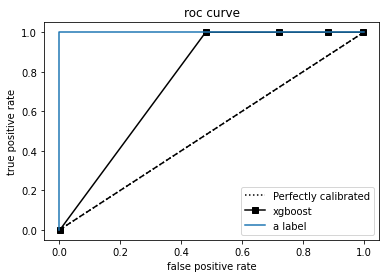

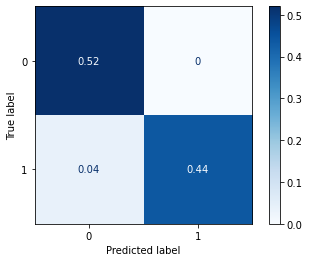

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

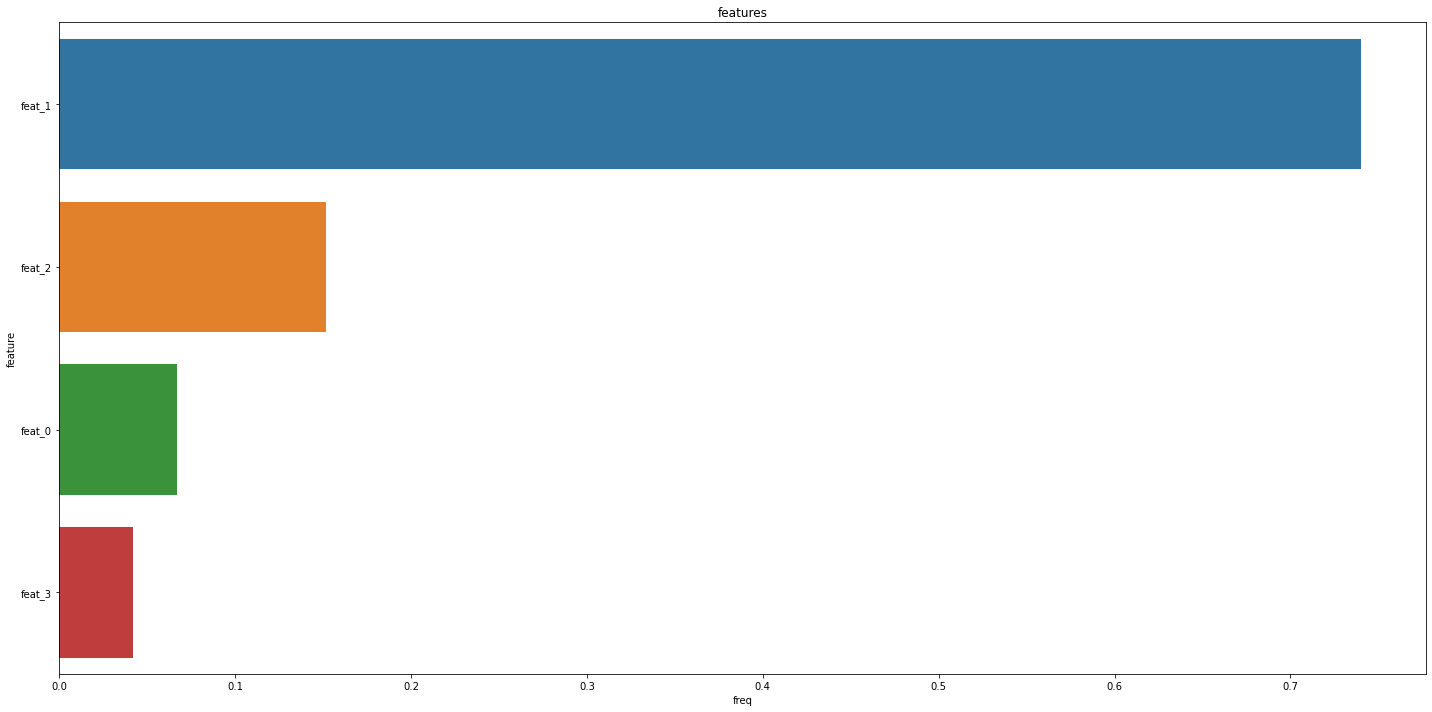

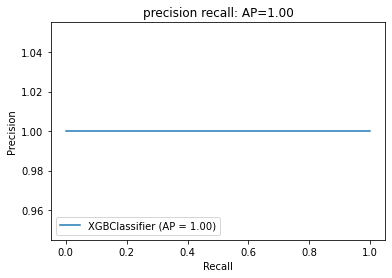

In [12]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":   f"{TEST_REPO}/{DATA_PATH}",
                        "models_path": f"{TEST_REPO}/{MODELS_PATH}"},
                artifact_path=mlconf.artifact_path + "/test-classifier")

### remotely

In [13]:
from mlrun import NewTask
run = fn.run(NewTask(**task_params), 
             inputs={"test_set":   f"{TEST_REPO}/{DATA_PATH}",
                     "models_path": f"{TEST_REPO}/{MODELS_PATH}"},
             artifact_path=mlconf.artifact_path + "/test-classifier")

[mlrun] 2020-05-25 01:22:26,018 starting run tasks test classifier uid=88416d4ebaca46748b70e744624f816d  -> http://mlrun-api:8080
[mlrun] 2020-05-25 01:22:28,329 Job is running in the background, pod: tasks-test-classifier-dgm52
[mlrun] 2020-05-25 01:22:54,802 warning!, server (kubeflow) and client (default-tenant) namespace dont match
[mlrun] 2020-05-25 01:22:54,813 starting local run: main.py # test_classifier
[mlrun] 2020-05-25 01:22:55,942 warning!, server (kubeflow) and client (default-tenant) namespace dont match
[mlrun] 2020-05-25 01:22:57,129 log artifact calibration curve at /home/jovyan/data/test-classifier/plots/calibration curve.html, size: 48016, db: Y
[mlrun] 2020-05-25 01:22:57,216 log artifact learning curve - auc at /home/jovyan/data/test-classifier/plots/learning curve - auc.html, size: 35899, db: Y
[mlrun] 2020-05-25 01:22:57,322 log artifact learning curve - erreur at /home/jovyan/data/test-classifier/plots/learning curve - erreur.html, size: 32838, db: Y
[mlrun] 20

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...4f816d,0,May 25 01:22:55,completed,tasks test classifier,kind=jobowner=jovyanhost=tasks-test-classifier-dgm52,test_setmodels_path,label_column=labelsplots_dest=sklearn_classifier/plots,"test-accuracy=0.96test-error=0.04rocauc=1.0brier_score=0.01445783954544383f1-score=0.9565217391304348precision_score=1.0recall_score=0.9166666666666666tables=[""{'key': 'feature-importances-tbl', 'kind': 'table', 'format': 'csv', 'header': ['freq', 'feature'], 'sources': [], 'project': ''}""]",calibration curvelearning curve - auclearning curve - erreurfeature-importancesconfusion-matrix-normalizedroc-binaryprecision-recall-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 88416d4ebaca46748b70e744624f816d  , !mlrun logs 88416d4ebaca46748b70e744624f816d 
[mlrun] 2020-05-25 01:23:02,605 run executed, status=completed
